### Imports

In [2]:
# Import necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from scipy.special import inv_boxcox

### Import data

In [28]:
# Load dataset
df = pd.read_csv('../data/data.csv')

# Label encoding for 'Country' due to high dimensionality
label_encoder = LabelEncoder()
df['Country'] = label_encoder.fit_transform(df['Country'])

# One-hot encoding for 'Region' due to low dimensionality
df_encoded = pd.get_dummies(df, columns=['Region'], drop_first=True)
df_encoded = df_encoded.astype(int)

# Separate features and target variable
X = df_encoded.drop(columns='Life_expectancy')
y = df_encoded['Life_expectancy']

# Apply Box-Cox transformation to the target (Life Expectancy)
# Box-Cox only accepts positive values, which are satisfied in life expectancy data
y_boxcox, lambda_val = boxcox(y)  # Store the lambda value for inverse transformation later if needed

# Updated feature matrix (X) and transformed target (y_boxcox)
X_transformed = X
y_transformed = pd.Series(y_boxcox, name="Life_expectancy_BoxCox")

# Save column names for reference after train/test split
feature_names = X_transformed.columns.tolist()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)

In [30]:
X.head()

,Country,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,...,Economy_status_Developed,Economy_status_Developing,Region_Asia,Region_Central America and Caribbean,Region_European Union,Region_Middle East,Region_North America,Region_Oceania,Region_Rest of Europe,Region_South America
0,164,2015,11,13,105,1,97,65,27,97,...,0,1,0,0,0,1,0,0,0,0
1,148,2015,2,3,57,10,97,94,26,97,...,1,0,0,0,1,0,0,0,0,0
2,74,2007,51,67,201,1,60,35,21,67,...,0,1,1,0,0,0,0,0,0,0
3,69,2006,32,40,222,5,93,74,25,92,...,0,1,0,0,0,0,0,0,0,1
4,79,2012,3,4,57,2,97,89,27,94,...,1,0,0,0,0,1,0,0,0,0


## Feature selection

### _Checking regression model accuracy metrics for optimal numbers of features_

Using a Sequential forward selection to find the best subsets both on the transformed data and the original data

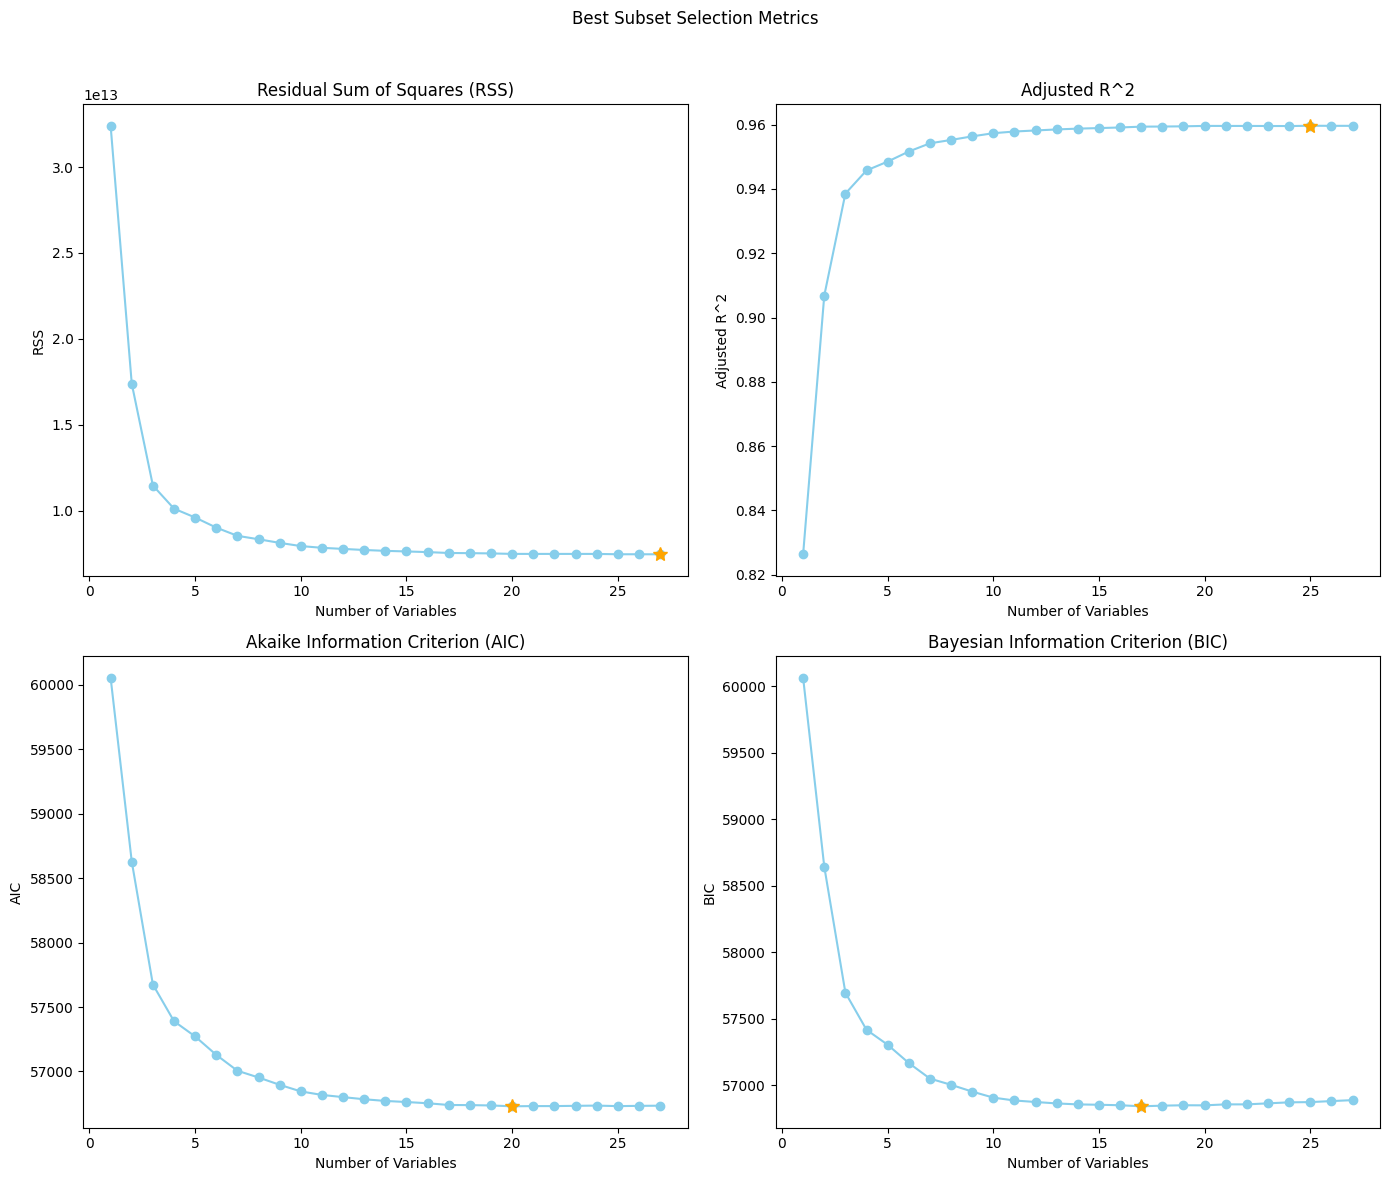

In [8]:
# Define the regression model
model = LinearRegression()

# Sequential forward selection to find best subsets up to all features
sfs_reg = SFS(model,
          k_features=(1, X_train.shape[1]),  # Test from 1 feature up to all features
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)

# Fit SFS on the transformed data
sfs_reg = sfs_reg.fit(X_train, y_train)

# Get the selection results for each subset size
results = sfs_reg.subsets_

# Initialize lists to store metrics for each subset size
rss_list = []
adj_r2_list = []
aic_list = []
bic_list = []
cp_list = []

# Total number of observations
n = X_train.shape[0]

# Calculate metrics for each subset
for subset_size in range(1, X_train.shape[1] + 1):
    # Extract selected feature indices for the current subset size
    selected_features_rg = list(results[subset_size]['feature_idx'])
    X_subset_rg = X_train.iloc[:, selected_features_rg]
    
    # Add a constant term for OLS regression
    X_subset_const_rg = add_constant(X_subset_rg)
    
    # Fit an OLS model and gather stats
    ols_model = OLS(y_train, X_subset_const_rg).fit()
    
    # Residual Sum of Squares (RSS)
    rss = ((ols_model.resid) ** 2).sum()
    rss_list.append(rss)
    
    # Adjusted R^2
    adj_r2_list.append(ols_model.rsquared_adj)
    
    # Akaike Information Criterion (AIC)
    aic_list.append(ols_model.aic)
    
    # Bayesian Information Criterion (BIC)
    bic_list.append(ols_model.bic)
    
    # Mallows' Cp
    mse_full = rss / (n - subset_size - 1)  # Mean squared error
    cp = rss / mse_full - (n - 2 * subset_size)
    cp_list.append(cp)

# Plotting metrics to find optimal subset size
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Best Subset Selection Metrics')

# Define a unified color for all plots
plot_color = 'skyblue'

# Plot RSS
axes[0, 0].plot(range(1, X_train.shape[1] + 1), rss_list, marker='o', color=plot_color)
axes[0, 0].set_xlabel('Number of Variables')
axes[0, 0].set_ylabel('RSS')
axes[0, 0].set_title('Residual Sum of Squares (RSS)')
axes[0, 0].plot(len(rss_list), rss_list[-1], marker='*', markersize=10, color="orange")  # Mark minimum RSS point

# Plot Adjusted R^2
axes[0, 1].plot(range(1, X_train.shape[1] + 1), adj_r2_list, marker='o', color=plot_color)
axes[0, 1].set_xlabel('Number of Variables')
axes[0, 1].set_ylabel('Adjusted R^2')
axes[0, 1].set_title('Adjusted R^2')
max_adjr2_idx = np.argmax(adj_r2_list) + 1
axes[0, 1].plot(max_adjr2_idx, adj_r2_list[max_adjr2_idx - 1], marker='*', markersize=10, color="orange")  # Mark max Adjusted R² point

# Plot AIC
axes[1, 0].plot(range(1, X_train.shape[1] + 1), aic_list, marker='o', color=plot_color)
axes[1, 0].set_xlabel('Number of Variables')
axes[1, 0].set_ylabel('AIC')
axes[1, 0].set_title('Akaike Information Criterion (AIC)')
min_aic_idx = np.argmin(aic_list) + 1
axes[1, 0].plot(min_aic_idx, aic_list[min_aic_idx - 1], marker='*', markersize=10, color="orange")  # Mark minimum AIC point

# Plot BIC
axes[1, 1].plot(range(1, X_train.shape[1] + 1), bic_list, marker='o', color=plot_color)
axes[1, 1].set_xlabel('Number of Variables')
axes[1, 1].set_ylabel('BIC')
axes[1, 1].set_title('Bayesian Information Criterion (BIC)')
min_bic_idx = np.argmin(bic_list) + 1
axes[1, 1].plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Mark minimum BIC point

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### _Forward selection_

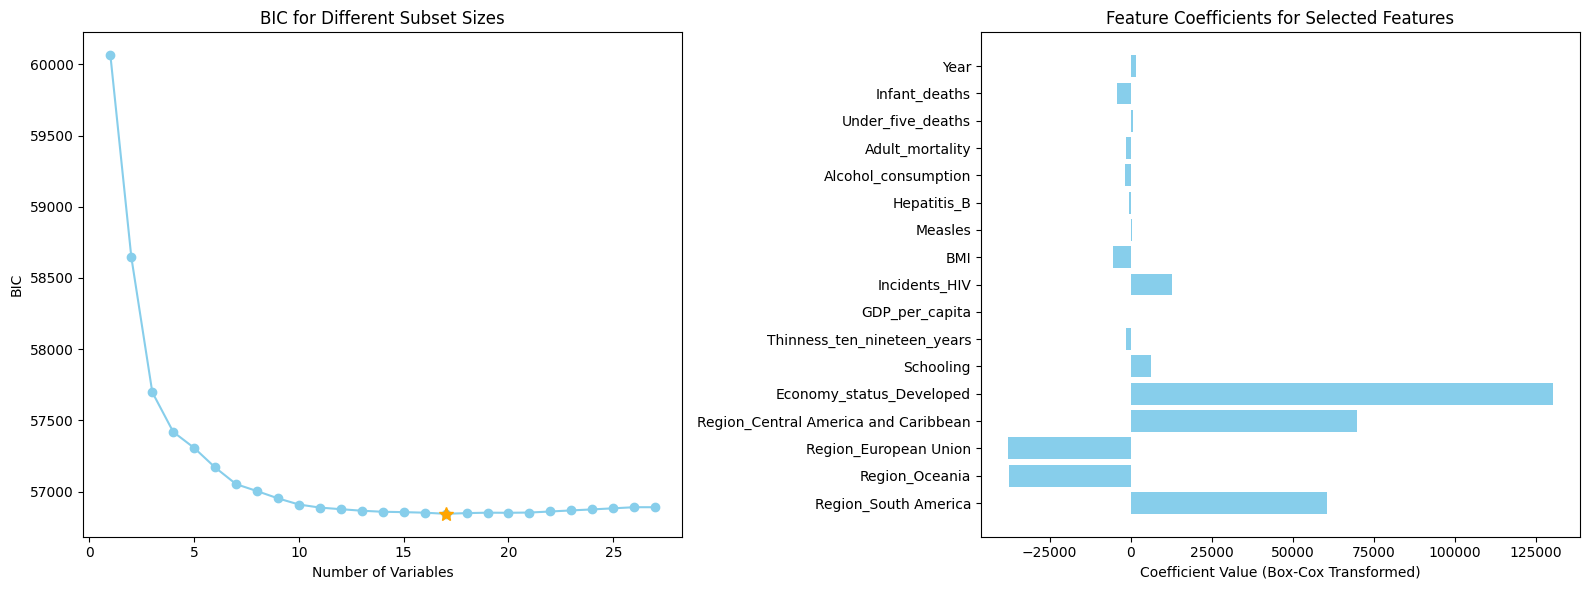

In [65]:
# Step 1: Forward Selection for Subset Selection with transformed data
model = LinearRegression()
sfs_fw = SFS(model,
          k_features=(1, X_train.shape[1]),  # Test from 1 feature up to max features
          forward=True,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs_fw = sfs_fw.fit(X_train, y_train)

# Step 2: Calculating BIC for each subset with transformed data
bic_list = []
n = len(y_train)

for subset_size in range(1, X_train.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs_fw.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train.iloc[:, selected_features]
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train, X_subset_const).fit()
    bic_list.append(ols_model.bic)
    
# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Refit the model on the optimal subset using the original target y
optimal_features_tr_fw = list(sfs_fw.subsets_[min_bic_idx]['feature_idx'])  # Get indices of optimal features
optimal_feature_names = [feature_names[i] for i in optimal_features_tr_fw]  # Get names of these features

# Re-fit on the original target variable y for interpretability
X_optimal = X_train.iloc[:, optimal_features_tr_fw]  # Optimal features from training set
X_optimal_df = pd.DataFrame(X_optimal, columns=optimal_feature_names)  # Convert to DataFrame for easier plotting
model.fit(X_optimal_df, y_train)
coefficients = model.coef_

# Plotting the coefficients
ax2.barh(optimal_feature_names, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value (Box-Cox Transformed)')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### _Backward Selection_

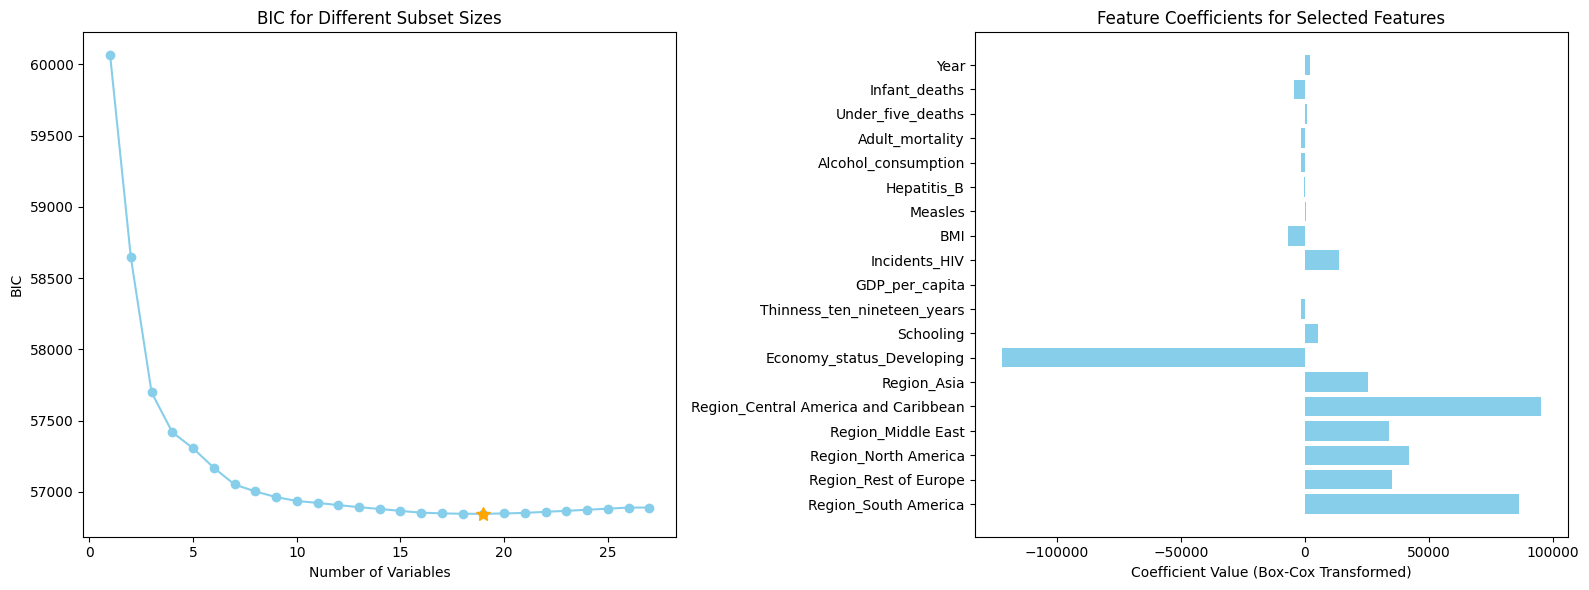

In [52]:
# Step 1: Forward Selection for Subset Selection with transformed data
model = LinearRegression()
sfs_bw = SFS(model,
          k_features=(1, X_train.shape[1]),  # Test from 1 feature up to max features
          forward=False,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs_bw = sfs_bw.fit(X_train, y_train)

# Step 2: Calculating BIC for each subset with transformed data
bic_list = []
n = len(y_train)

for subset_size in range(1, X_train.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs_bw.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train.iloc[:, selected_features]
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train, X_subset_const).fit()
    bic_list.append(ols_model.bic)
    
# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Refit the model on the optimal subset using the original target y
optimal_features_tr_bw = list(sfs_bw.subsets_[min_bic_idx]['feature_idx'])  # Get indices of optimal features
optimal_feature_names = [feature_names[i] for i in optimal_features_tr_bw]  # Get names of these features

# Re-fit on the original target variable y for interpretability
X_optimal = X_train.iloc[:, optimal_features_tr_bw]  # Optimal features from training set
X_optimal_df = pd.DataFrame(X_optimal, columns=optimal_feature_names)  # Convert to DataFrame for easier plotting
model.fit(X_optimal_df, y_train)
coefficients = model.coef_

# Plotting the coefficients
ax2.barh(optimal_feature_names, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value (Box-Cox Transformed)')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Original Data

### _Import Data_

In [ ]:
df = pd.read_csv('../data/data.csv')

# Use label encoding for Country because of high dimensionality (193 unique values)
label_encoder = LabelEncoder()
df['Country'] = label_encoder.fit_transform(df['Country'])

region_column = df['Region']

# Use one-hot encoding for Region because of low dimensionality (6 unique values)
df_encoded = pd.get_dummies(df, columns=['Region'], drop_first=True)
df_encoded = df_encoded.astype(int)

y_original = df['Life_expectancy'].values
X_og = df_encoded.drop(columns='Life_expectancy')
y_og = df_encoded['Life_expectancy']

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y_og, test_size=0.2, random_state=42)

### _Checking regression model accuracy metrics for optimal numbers of features_

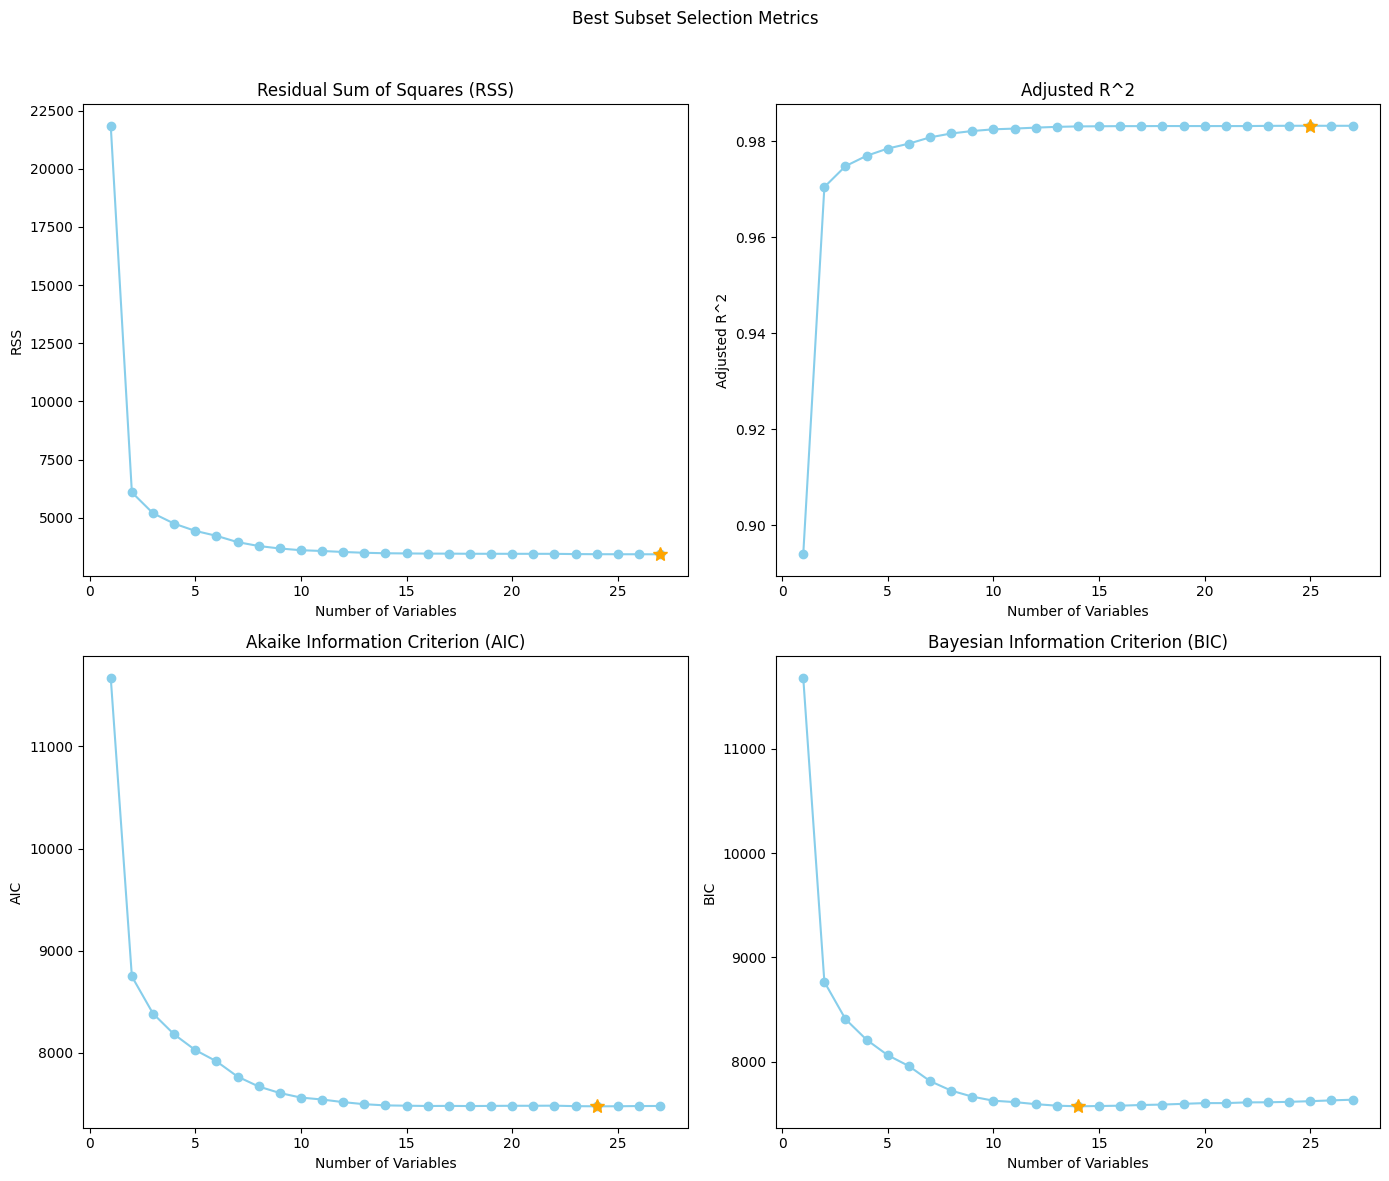

In [12]:
# Define the regression model
model = LinearRegression()

# Sequential forward selection to find best subsets up to all features
sfs = SFS(model,
          k_features=(1, X_train_og.shape[1]),  # Test from 1 feature up to all features
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)

# Fit SFS on the data
sfs = sfs.fit(X_train_og, y_train_og)

# Get the selection results for each subset size
results = sfs.subsets_

# Ensure X is a NumPy array
X_train_og = np.array(X_train_og)

# Initialize lists to store metrics for each subset size
rss_list = []
adj_r2_list = []
aic_list = []
bic_list = []
cp_list = []

# Total number of observations
n = X_train_og.shape[0]

# Calculate metrics for each subset
for subset_size in range(1, X_train_og.shape[1] + 1):
    # Extract selected feature indices for the current subset size
    selected_features = list(results[subset_size]['feature_idx'])
    X_subset = X_train_og[:, selected_features]
    
    # Add a constant term for OLS regression
    X_subset_const = add_constant   (X_subset)
    
    # Fit an OLS model and gather stats
    ols_model = OLS(y_train_og, X_subset_const).fit()
    
    # Residual Sum of Squares (RSS)
    rss = ((ols_model.resid) ** 2).sum()
    rss_list.append(rss)
    
    # Adjusted R^2
    adj_r2_list.append(ols_model.rsquared_adj)
    
    # Akaike Information Criterion (AIC)
    aic_list.append(ols_model.aic)
    
    # Bayesian Information Criterion (BIC)
    bic_list.append(ols_model.bic)
    
    # Mallows' Cp
    mse_full = rss / (n - subset_size - 1)  # Mean squared error
    cp = rss / mse_full - (n - 2 * subset_size)
    cp_list.append(cp)

# Plotting metrics to find optimal subset size
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Best Subset Selection Metrics')

# Define a unified color for all plots
plot_color = 'skyblue'

# Plot RSS
axes[0, 0].plot(range(1, X_train_og.shape[1] + 1), rss_list, marker='o', color=plot_color)
axes[0, 0].set_xlabel('Number of Variables')
axes[0, 0].set_ylabel('RSS')
axes[0, 0].set_title('Residual Sum of Squares (RSS)')
axes[0, 0].plot(len(rss_list), rss_list[-1], marker='*', markersize=10, color="orange")  # Mark minimum RSS point

# Plot Adjusted R^2
axes[0, 1].plot(range(1, X_train_og.shape[1] + 1), adj_r2_list, marker='o', color=plot_color)
axes[0, 1].set_xlabel('Number of Variables')
axes[0, 1].set_ylabel('Adjusted R^2')
axes[0, 1].set_title('Adjusted R^2')
max_adjr2_idx = np.argmax(adj_r2_list) + 1
axes[0, 1].plot(max_adjr2_idx, adj_r2_list[max_adjr2_idx - 1], marker='*', markersize=10,  color="orange")  # Mark max Adjusted R² point

# Plot AIC
axes[1, 0].plot(range(1, X_train_og.shape[1] + 1), aic_list, marker='o', color=plot_color)
axes[1, 0].set_xlabel('Number of Variables')
axes[1, 0].set_ylabel('AIC')
axes[1, 0].set_title('Akaike Information Criterion (AIC)')
min_aic_idx = np.argmin(aic_list) + 1
axes[1, 0].plot(min_aic_idx, aic_list[min_aic_idx - 1], marker='*', markersize=10, color="orange")  # Mark minimum AIC point

# Plot BIC
axes[1, 1].plot(range(1, X_train_og.shape[1] + 1), bic_list, marker='o', color=plot_color)
axes[1, 1].set_xlabel('Number of Variables')
axes[1, 1].set_ylabel('BIC')
axes[1, 1].set_title('Bayesian Information Criterion (BIC)')
min_bic_idx = np.argmin(bic_list) + 1
axes[1, 1].plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*',markersize=10, color="orange")  # Mark minimum BIC point

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### _Backward Selection_

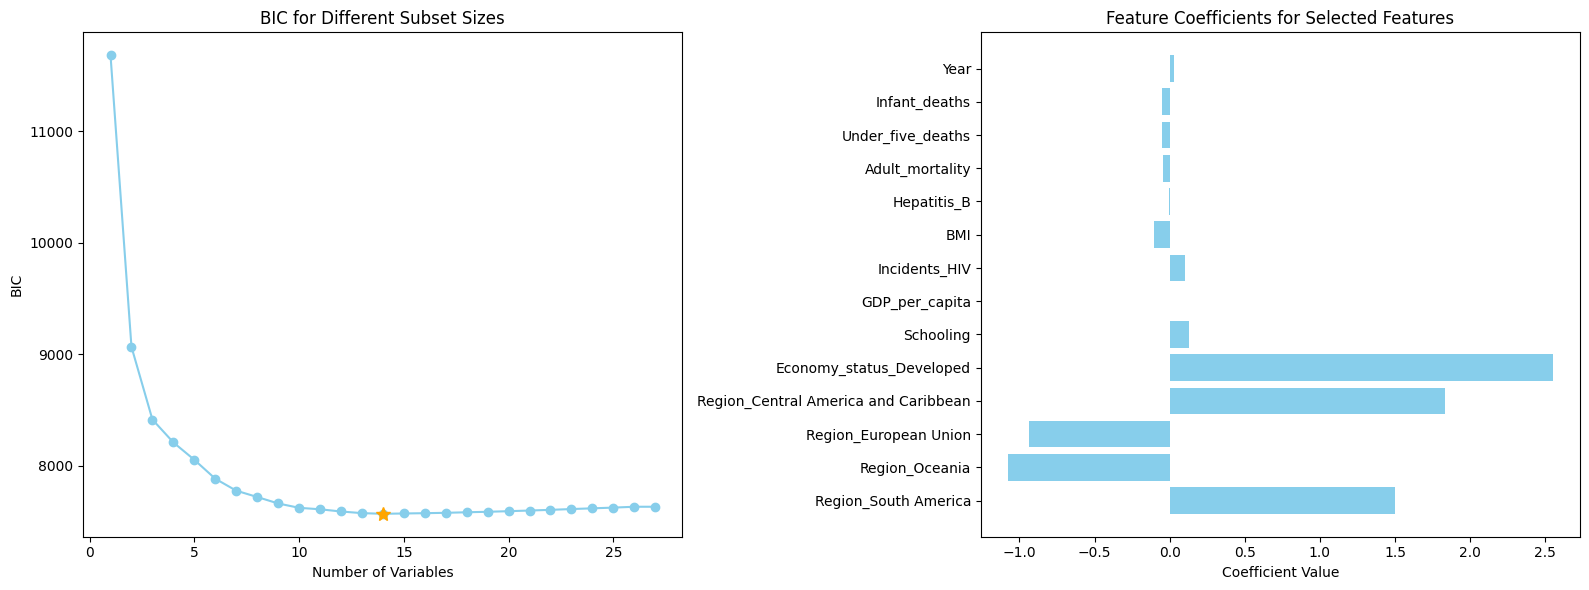

In [46]:
# Step 1: Backward Selection for Subset Selection
model = LinearRegression()
sfs = SFS(model,
          k_features=(1, X_train_og.shape[1]),  # Test from 1 feature up to max features
          forward=False,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs = sfs.fit(X_train_og, y_train_og)

# Step 2: Calculating BIC for each subset
bic_list = []
n = len(y_train_og)

for subset_size in range(1, X_train_og.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train_og[:, selected_features] 
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train_og, X_subset_const).fit()
    bic_list.append(ols_model.bic)

# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train_og.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Plot the selected features in the optimal subset on the second subplot
optimal_features_og_bw = sfs.subsets_[min_bic_idx]['feature_idx']  # Get indices of optimal features

# Fit the model on the optimal subset
X_optimal = X_train_og[:, list(optimal_features_og_bw)]
model.fit(X_optimal, y_train_og)
coefficients = model.coef_
feature_names_og = X_og.columns[list(optimal_features_og_bw)]

# Plotting the coefficients
ax2.barh(feature_names_og, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### _Forward Selection_

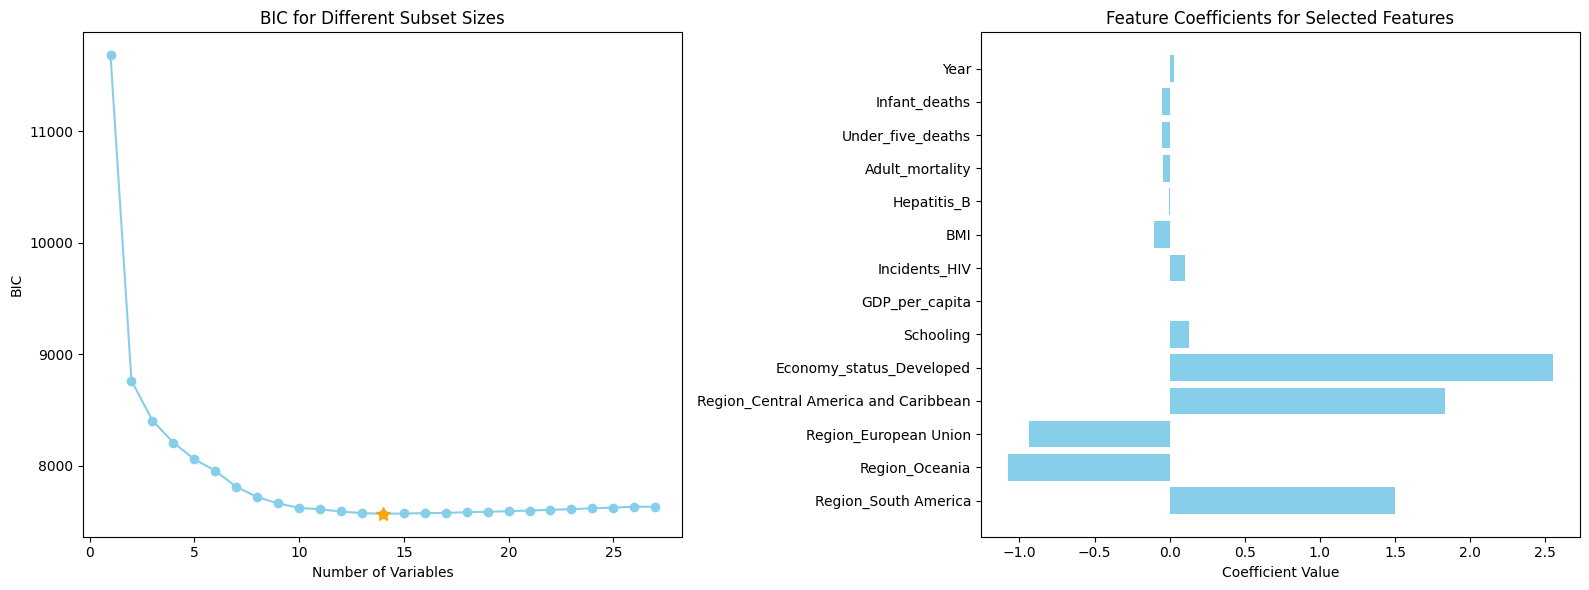

In [62]:
# Step 1: Backward Selection for Subset Selection
model = LinearRegression()
sfs = SFS(model,
          k_features=(1, X_train_og.shape[1]),  # Test from 1 feature up to max features
          forward=True,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs = sfs.fit(X_train_og, y_train_og)

# Step 2: Calculating BIC for each subset
bic_list = []
n = len(y_train_og)

for subset_size in range(1, X_train_og.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train_og[:, selected_features] 
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train_og, X_subset_const).fit()
    bic_list.append(ols_model.bic)

# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train_og.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Plot the selected features in the optimal subset on the second subplot
optimal_features_og_fw = sfs.subsets_[min_bic_idx]['feature_idx']  # Get indices of optimal features
feature_names_og = X_og.columns[list(optimal_features_og_fw)]      # Get names of these features

# Fit the model on the optimal subset
X_optimal = X_train_og[:, list(optimal_features_og_fw)]
model.fit(X_optimal, y_train_og)
coefficients = model.coef_

# Plotting the coefficients
ax2.barh(feature_names_og, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Models

In [61]:
# print feature names in optimal feature subset tr_fw
print(X_og.columns[optimal_features_tr_fw])


print(optimal_features_og_bw)


Index(['Year', 'Infant_deaths', 'Under_five_deaths', 'Adult_mortality',
       'Alcohol_consumption', 'Hepatitis_B', 'Measles', 'BMI', 'Incidents_HIV',
       'GDP_per_capita', 'Thinness_ten_nineteen_years', 'Schooling',
       'Economy_status_Developed', 'Region_Central America and Caribbean',
       'Region_European Union', 'Region_Oceania', 'Region_South America'],
      dtype='object')
(1, 2, 3, 4, 6, 8, 11, 12, 16, 17, 20, 21, 24, 26)


In [82]:
print(X_test.iloc[:, list(optimal_features_og_bw)].columns)

Index(['Year', 'Infant_deaths', 'Under_five_deaths', 'Adult_mortality',
       'Hepatitis_B', 'BMI', 'Incidents_HIV', 'GDP_per_capita', 'Schooling',
       'Economy_status_Developed', 'Region_Central America and Caribbean',
       'Region_European Union', 'Region_Oceania', 'Region_South America'],
      dtype='object')


In [102]:
# Step 1: Predict the target variable on the test set (in transformed space)
model = LinearRegression()
model.fit(X_train.iloc[:, list(optimal_features_tr_fw)], y_train)

y_pred = model.predict(X_test.iloc[:, list(optimal_features_tr_fw)])

# Step 2: Calculate R² on the transformed data (Box-Cox scale)
r2_score = model.score(X_test.iloc[:, list(optimal_features_tr_fw)], y_test)


# Step 5: Print the R² scores
print(f'R² Score on Transformed Data: {r2_score:.4f}')



R² Score on Transformed Data: 0.9537


In [164]:
print(type(X_train_og))
print(type(X_train))
print(type(X_test_og))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


(array([   0,    0,    0, ..., 2290, 2290, 2290], dtype=int64), array([ 0,  1,  2, ..., 24, 25, 26], dtype=int64))


R² Score on Transformed Data: 0.9812 for Original Data Backward Selection
MSE: 1.56882877176645
R² Score on Transformed Data: 0.9812 for Original Data Forward Selection
MSE: 1.56882877176645
R² Score on Transformed Data: 0.9529 for Box-Cox Transformed Data Backward Selection
MSE: 15.085729927832569
R² Score on Transformed Data: 0.9537 for Box-Cox Transformed Data Forward Selection
MSE: 15.144200916262747


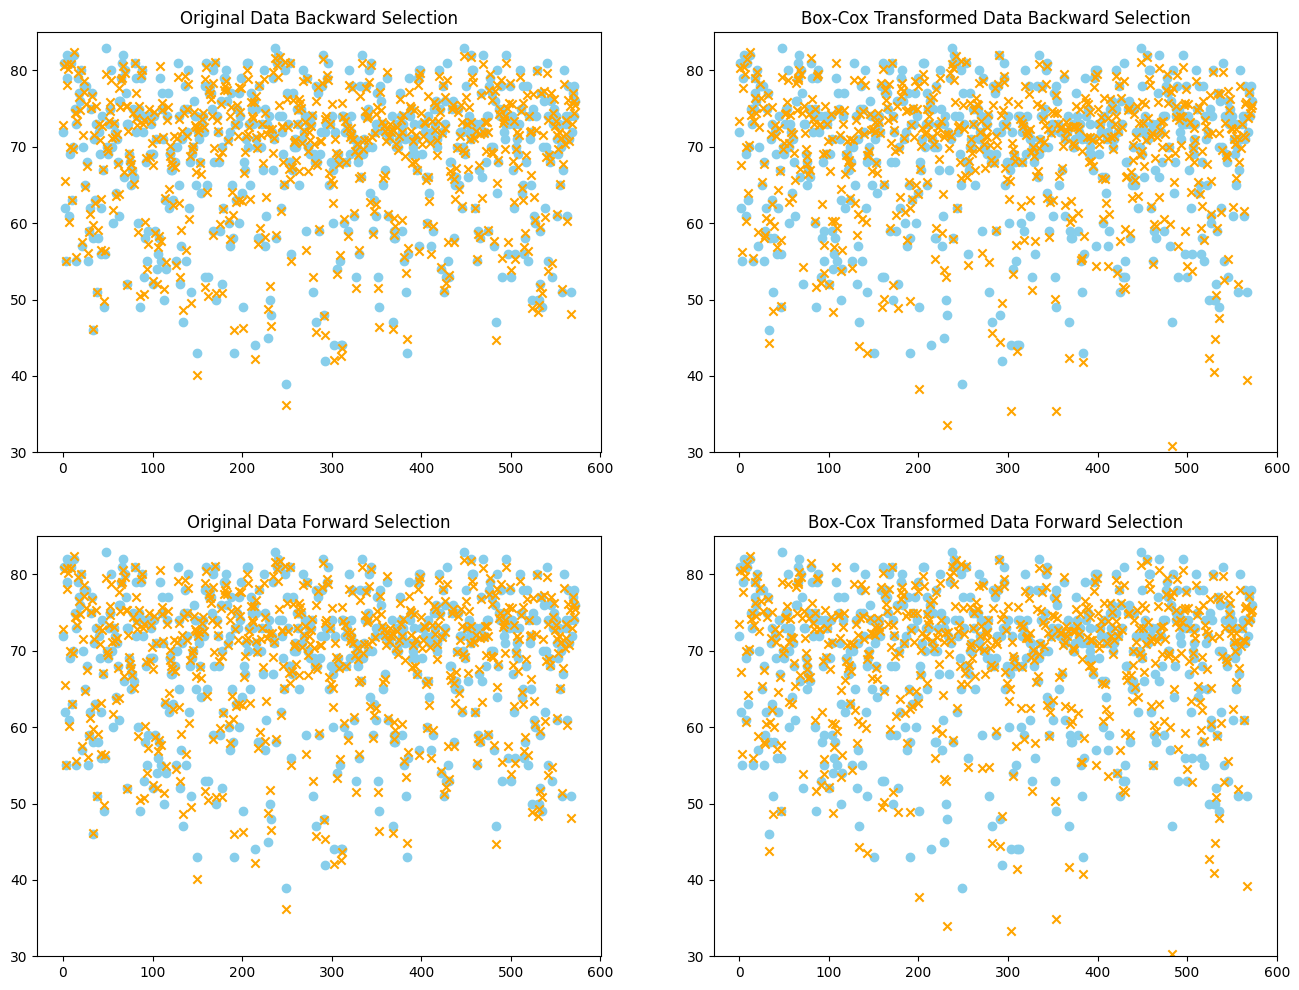

In [206]:
optimal_features = [optimal_features_og_bw, optimal_features_og_fw, optimal_features_tr_bw, optimal_features_tr_fw]
names = ["Original Data Backward Selection", "Original Data Forward Selection", "Box-Cox Transformed Data Backward Selection", "Box-Cox Transformed Data Forward Selection"]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
i = 0
j = 0
for optimals in optimal_features:
    model = LinearRegression()
    this_X = None
    this_y = None
    y_pred = None
    r2_score = None
    if "Original" in names[i+j*2]:
        this_X = X_train_og
        this_X = pd.DataFrame(this_X, columns=X_og.columns)
        this_y = y_train_og
        test_y = y_test_og
        model.fit(this_X.iloc[:, list(optimals)], this_y)
    	
        y_pred = model.predict(X_test_og.iloc[:, list(optimals)])
        r2_score = model.score(X_test_og.iloc[:, list(optimals)], y_test_og)

    else:
        this_X = X_train
        this_y = y_train
        test_y = y_test
        model.fit(this_X.iloc[:, list(optimals)], y_train)
    	
        y_pred = model.predict(X_test.iloc[:, list(optimals)])
        r2_score = model.score(X_test.iloc[:, list(optimals)], y_test)
        

    # Step 5: Print the R² scores
    print(f'R² Score on Transformed Data: {r2_score:.4f} for {names[i+j*2]}')

    # print x if nan
    
    if "Transformed" in names[i+j*2]:
        revers_transformed_pred = inv_boxcox(y_pred, lambda_val)
        revers_transformed_test = inv_boxcox(test_y, lambda_val)
        test_y = revers_transformed_test
        y_pred = revers_transformed_pred
        y_pred = [0 if np.isnan(x) else x for x in y_pred]
       

    print("MSE:", mean_squared_error(test_y, y_pred))
    
        
    axes[i, j].scatter(range(0, len(test_y)), test_y, color='skyblue', marker='o')
    axes[i, j].scatter(range(0, len(y_pred)), y_pred, color='orange', marker='x')
    axes[i, j].set_title(names[i+j*2])
    # set scale of y axis to 30 - 90
    axes[i, j].set_ylim([30, 85])

    i += 1
    if i == 2:
        i = 0
        j += 1

# colorbar

plt.show()
# replace nan with 0
revers_transformed_pred = [0 if np.isnan(x) else x for x in revers_transformed_pred]


In [ ]:
# Step 1: Predict the target variable on the test set (in transformed space)
y_pred = model.predict(X_test.iloc[:, list(optimal_features_og_bw)])

# Step 2: Calculate R² on the transformed data (Box-Cox scale)
r2_score = model.score(X_test.iloc[:, list(optimal_features_og_bw)], y_test)

# Step 3: Inverse Box-Cox transformation to get the original target values
y_pred_original = inv_boxcox(y_pred, lambda_val)
y_test_original = inv_boxcox(y_test, lambda_val)

# Step 4: Calculate the R² score on the original target values
r2_score_original = np.corrcoef(y_pred_original, y_test_original)[0, 1] ** 2

# Step 5: Print the R² scores
print(f'R² Score on Transformed Data: {r2_score:.4f}')
print(f'R² Score on Original Data: {r2_score_original:.4f}')

R² Score on Transformed Data: -6.5461
R² Score on Original Data: 0.9738


c:\Users\Malin Haugland Høli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Malin Haugland Høli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [66]:
# Step 1: Predict the target variable on the test set (in transformed space)
y_pred = model.predict(X_test.iloc[:, optimal_features_tr_fw])

# Step 2: Calculate R² on the transformed data (Box-Cox scale)
r2_score = model.score(X_test.iloc[:, list(optimal_features_tr_fw)], y_test)

# Step 5: Print the R² scores
print(f'R² Score on Transformed Data: {r2_score:.4f}')

R² Score on Transformed Data: 0.9537


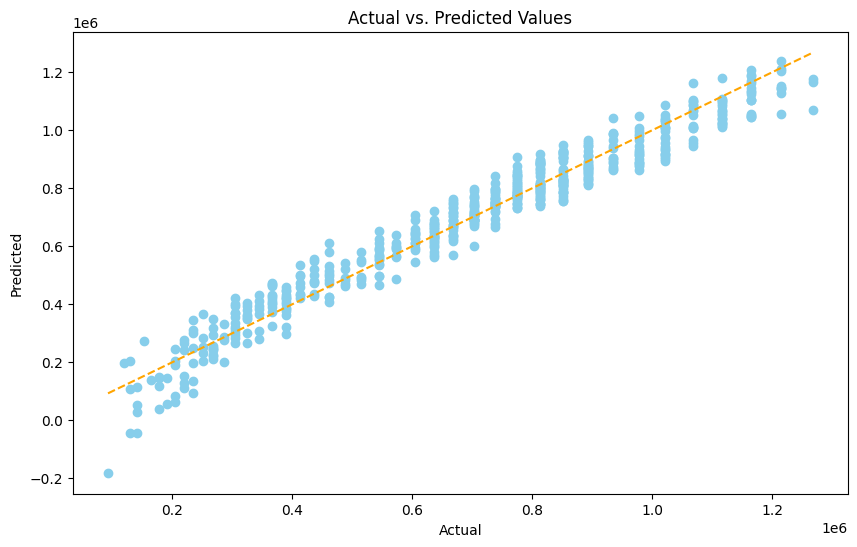

In [67]:
# plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='orange')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

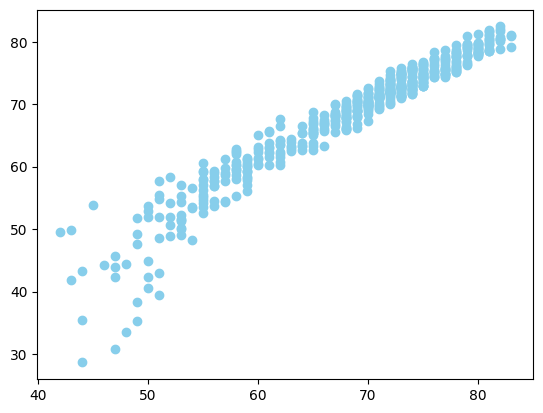

In [68]:
plt.scatter(y_test_original, y_pred_original, color='skyblue')